# Stellarator Optimization

This tutorial demonstrates how to perform optimization with DESC. It will go through two examples: 1) targeting the "triple product" quasi-symmetry objective $f_T$ in the full plasma volume 2) targeting the "two-term" objective $f_C$ for quasi-helical symmetry at the plasma boundary surface. These examples are adapted from a problem first presented in [Rodriguez et al (2022)](https://www.cambridge.org/core/journals/journal-of-plasma-physics/article/measures-of-quasisymmetry-for-stellarators/01B9DFE86A23964F331E0E0615B4E7A2) and reproduced in [Dudt et al (2022)](https://arxiv.org/abs/2204.00078). 

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('.'))
sys.path.append(os.path.abspath('../../'))

If you have acess to a GPU, uncomment the line `set_device("gpu")`. You should see about an order of magnitude speed improvement with only this single line of code! 

In [2]:
from desc import set_device
# set_device("gpu")

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 12

import desc.io
from desc.grid import LinearGrid, ConcentricGrid
from desc.objectives import (
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixIota,
    FixPsi,
    AspectRatio,
    ForceBalance,
    QuasisymmetryBoozer,
    QuasisymmetryTwoTerm,
    QuasisymmetryTripleProduct,
)
from desc.optimize import Optimizer
from desc.plotting import plot_grid, plot_boozer_modes, plot_boozer_surface, plot_qs_error

DESC version 0.5.0+109.g58f4898, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 18.08 GB available memory


To save time during this tutorial, we will load an equilibrium solution to use as the initial guess for optimization. This equilibrium is already somewhat close to quasi-helical symmetry (QH) but can be improved. 

In [4]:
# load initial equilibrium
eq_init = desc.io.load("qs_initial_guess.h5")

There are several plotting functions available in DESC that are useful for visualizing the quasi-symmetry (QS) errors. Let us look at the initial errors before optimization: 

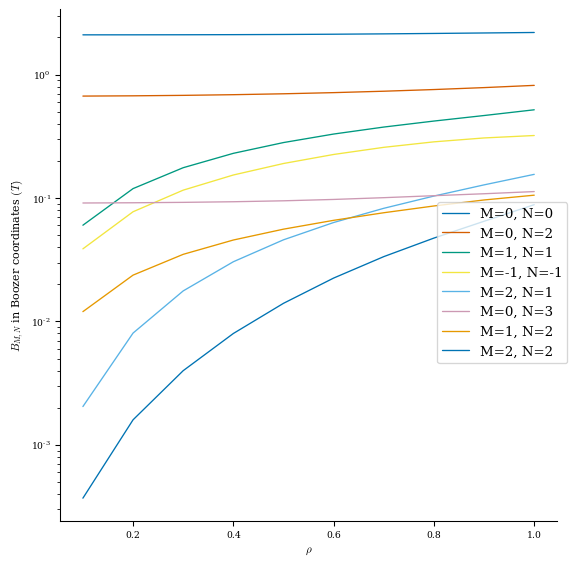

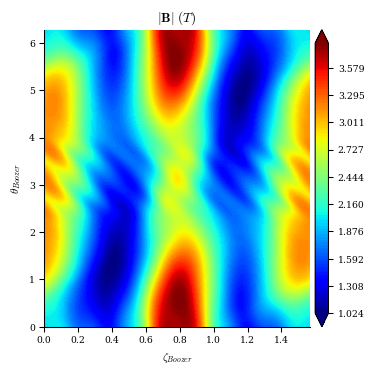

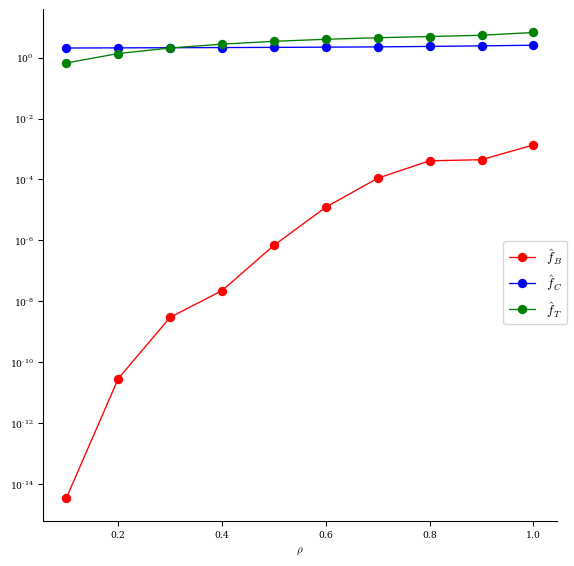

In [6]:
plot_boozer_modes(eq_init, num_modes=8, rho=10);  # plot modes of |B| in Boozer coordinates
plot_boozer_surface(eq_init);  # plot |B| contours in Boozer coordinates on a surface (default is rho=1)
plot_qs_error(eq_init, helicity=(1, eq_init.NFP), rho=10);  # plot normalized QS metrics

The last plot shows the three different QS errors implemented in DESC. Their definitions and the normalized scalar quantities plotted for each flux surface are shown below: 

### Boozer Coordinates

This is the "traditional" definition of QS. The drawbacks of this metric are that Boozer coordinates are expensive to compute, and it only provides "global" information about the error on each surface. But it has the nice property of $\hat{f}_B \in [0,1]$. 

\begin{equation}
|\mathbf{B}| = B(\psi, M\vartheta_{B} - N\zeta_{B})
\end{equation}

\begin{equation}
\mathbf{f}_{B} = \{ B_{mn} ~|~ m/n \neq M/N \}
\end{equation}

\begin{equation}
\hat{f}_{B} = \frac{|\mathbf{f}_{B}|}{\sqrt{\sum_{m,n} B_{mn}^2}}
\end{equation}

### Two-Term

This definition is advantageous because it does not require a transformation to Boozer coordinates and it reveals "local" errors within a flux surface. 

\begin{equation}
f_{C} = \left( M \iota - N \right) \left( \mathbf{B} \times \nabla \psi \right) \cdot \nabla B - \left( M G + N I \right) \mathbf{B} \cdot \nabla B. 
\end{equation}

\begin{equation}
\mathbf{f}_{C} = \{ f_{C}(\theta_{i},\zeta_{j}) ~|~ i \in [0,2\pi), j \in [0,2\pi/N_{FP}) \}
\end{equation}

\begin{equation}
\hat{f}_{C} = \frac{\langle |f_C| \rangle}{\langle B \rangle^3}.
\end{equation}

### Triple Product

This is also a local error metric that can be evaluated without Boozer coordinates. The potential advantages of this definition are that it does not require specifying the helicity (type of quasi-symmetry) and does not assume $\mathbf{J}\cdot\nabla\psi=0$. 

\begin{equation}
f_{T} = \nabla \psi \times \nabla B \cdot \nabla \left( \mathbf{B} \cdot \nabla B \right)
\end{equation}

\begin{equation}
\label{eq:fT_vec}
\mathbf{f}_{T} = \{ f_{T}(\theta_{i},\zeta_{j}) ~|~ i \in [0,2\pi), j \in [0,2\pi/N_{FP}) \}
\end{equation}

\begin{equation}
\label{eq:fT_hat}
\hat{f}_{T}(\psi) = \frac{\langle R \rangle^2 \langle |f_{T}| \rangle}{\langle B \rangle^4}
\end{equation}

To set up the optimization problem, we need to choose an optimization algorithm. `"lsq-exact"` is a custom least-squares routine, but there are other options available ([see documentation](https://desc-docs.readthedocs.io/en/latest/_api/optimize/desc.optimize.Optimizer.html)). 

In [7]:
optimizer = Optimizer("lsq-exact")

Next we need to define the optimization constraints. In DESC we explicitly specify the constraints, and all other parameters become free variables for optimization. In this example, we would like the following 4 stellarator-symmetric boundary coefficients to be our only optimization variables: 

\begin{multline}
\\
R^{b}_{1,2} \cos(\theta) \cos(2N_{FP}\phi) \\
R^{b}_{-1,-2} \sin(\theta) \sin(2N_{FP}\phi) \\
Z^{b}_{-1,2} \sin(\theta) \cos(2N_{FP}\phi) \\
Z^{b}_{1,-2} \cos(\theta) \sin(2N_{FP}\phi) \\
\\
\end{multline}

We will fix all other boundary modes besides these ones. We will also fix the pressure profile, rotational transform profile, and total toroidal magnetic flux. Finally, we also specify equilibrium force balance as a constraint by including the `ForceBalance()` objective in the list of constraints. 

In [8]:
# indices of boundary modes we want to optimize
idx_Rcc = eq_init.surface.R_basis.get_idx(M=1, N=2)
idx_Rss = eq_init.surface.R_basis.get_idx(M=-1, N=-2)
idx_Zsc = eq_init.surface.Z_basis.get_idx(M=-1, N=2)
idx_Zcs = eq_init.surface.Z_basis.get_idx(M=1, N=-2)

# boundary modes to constrain
R_modes = np.delete(eq_init.surface.R_basis.modes, [idx_Rcc, idx_Rss], axis=0)
Z_modes = np.delete(eq_init.surface.Z_basis.modes, [idx_Zsc, idx_Zcs], axis=0)

# constraints
constraints = (
    ForceBalance(),  # enforce JxB-grad(p)=0 during optimization
    FixBoundaryR(modes=R_modes),  # fix specified R boundary modes
    FixBoundaryZ(modes=Z_modes),  # fix specified Z boundary modes
    FixPressure(),  # fix pressure profile
    FixIota(),  # fix rotational transform profile
    FixPsi(),  # fix total toroidal magnetic flux
)

## Triple Product QS in Volume

First we are going to optimize for QS using the "triple product" objective, evaluated throughout the plasma volume. We start by creating the grid of collocation points where we want the $f_T$ errors to be evaluated. We then initialize the appropriate objective function with this grid. 

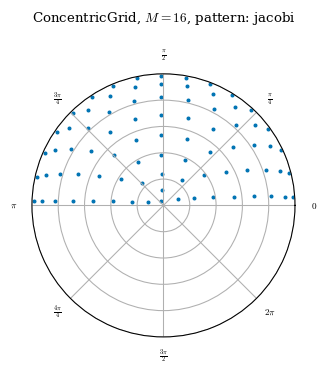

In [9]:
# objective
grid_vol = ConcentricGrid(L=eq_init.L_grid, M=eq_init.M_grid, N=eq_init.N_grid, NFP=eq_init.NFP, sym=eq_init.sym)
plot_grid(grid_vol);
objective_fT = ObjectiveFunction(QuasisymmetryTripleProduct(grid=grid_vol), verbose=0)

We are now ready to run the optimization problem. The syntax is shown below with many of the optimization options that are available -- you can try changing these parameters. 

In [10]:
eq_qs_T, result_T = eq_init.optimize(
    objective=objective_fT,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-2,  # stopping tolerance on the function value
    xtol=1e-6,  # stopping tolerance on the step size
    gtol=1e-6,  # stopping tolerance on the gradient
    maxiter=50,  # maximum number of iterations
    options={
        "perturb_options": {"order": 2, "verbose": 0},  # use 2nd-order perturbations
        "solve_options": {"ftol": 1e-2, "xtol": 1e-6, "gtol": 1e-6, "verbose": 0}, # for equilibrium subproblem
    },
    copy=True,  # return a new Equilibrium object (copy=False will overwrite the original)
    verbose=3,
)

Building objective: QS triple product
Precomputing transforms
Timer: Precomputing transforms = 438 ms
Timer: Objecive build = 445 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 201 ms
Timer: Objecive build = 212 ms
Factorizing linear constraints
Timer: linear constraint factorize = 306 ms
Number of parameters: 4
Number of objectives: 1377
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.8302e+02                                    1.05e+05    
       1              2         1.0964e+02      6.73e+02       3.35e-02       1.32e+04    
       2              3         1.8278e+01      9.14e+01       3.70e-02       1.99e+03    
       3              4         2.7099e+00      1.56e+01       2.92e-02       3.06e+02    
       4              5         3.7698e-01      2.33e+00       1.80e-02       5.65e+01    
       5              6         7.3721e-02      3.03

Let us plot the QS errors again to see how well the optimization worked: 

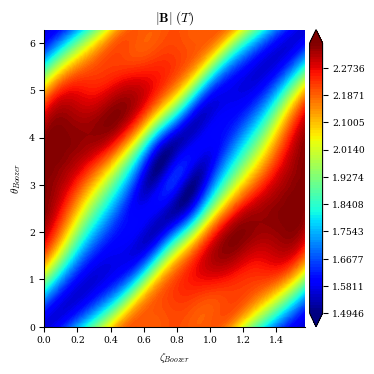

In [11]:
plot_boozer_surface(eq_qs_T);  # |B| contours at rho=1 surface

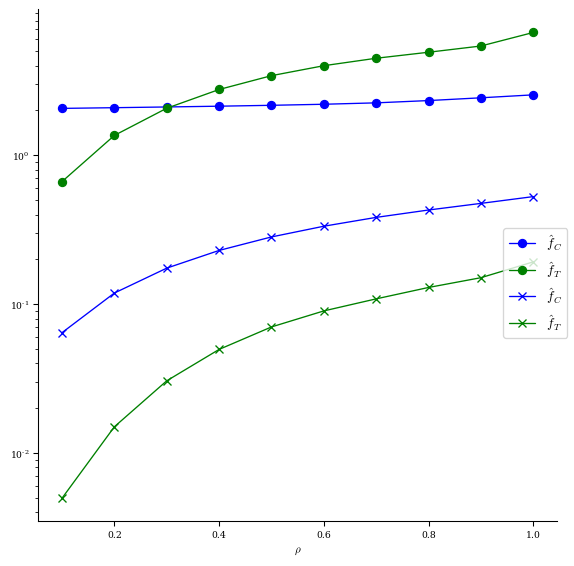

In [13]:
# compare f_T & f_C before (o) vs after (x) optimization
fig, ax = plot_qs_error(eq_init, helicity=(1, eq_init.NFP), fB=False, legend=False, rho=10);
plot_qs_error(eq_qs_T, helicity=(1, eq_init.NFP), fB=False, ax=ax, markers=["x", "x"], rho=10);

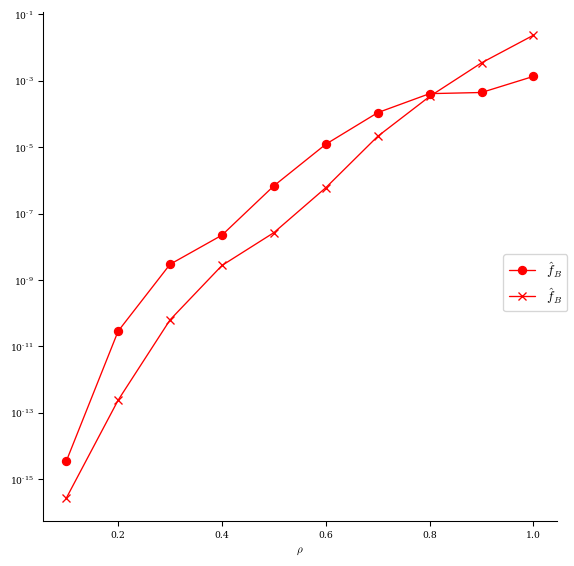

In [16]:
# compare f_B before (o) vs after (x) optimization
fig, ax = plot_qs_error(eq_init, helicity=(1, eq_init.NFP), fT=False, fC=False, legend=False, rho=10);
plot_qs_error(eq_qs_T, helicity=(1, eq_init.NFP), fT=False, fC=False, ax=ax, markers=["x"], rho=10);

## Two-Term QH at Boundary Surface

Next we are going to optimize for QH using the "two-term" objective, evaluated at the $\rho=1$ flux surface. Again we need to create the grid of collocation points where we want the $f_C$ errors to be evaluated. We then initialize the appropriate objective function with this grid. 

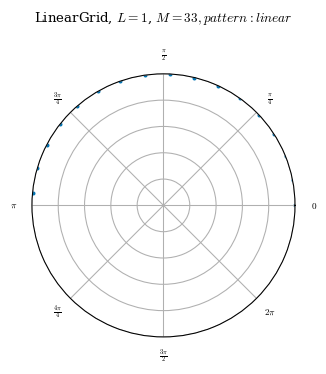

In [17]:
grid_rho1 = LinearGrid(M=2 * eq_init.M_grid + 1, N=2 * eq_init.N_grid + 1, NFP=eq_init.NFP, sym=eq_init.sym, rho=1.0)
plot_grid(grid_rho1);
objective_fC = ObjectiveFunction(QuasisymmetryTwoTerm(grid=grid_rho1, helicity=(1, eq_init.NFP)), verbose=0)

Now we can re-run the optimization from the same intial guess as before, but using this different objective function. We can reuse the same `optimizer` and `constraints` from the first run. 

In [18]:
eq_qs_C, result_C = eq_init.optimize(
    objective=objective_fC,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-2,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=50,
    options={
        "perturb_options": {"order": 2, "verbose": 0},
        "solve_options": {"ftol": 1e-2, "xtol": 1e-6, "gtol": 1e-6, "verbose": 0},
    },
    copy=True,
    verbose=3,
)

Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 372 ms
Timer: Objecive build = 380 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 217 ms
Timer: Objecive build = 223 ms
Factorizing linear constraints
Timer: linear constraint factorize = 47.4 ms
Number of parameters: 4
Number of objectives: 289
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3674e+03                                    1.16e+05    
       1              2         3.8224e+02      1.99e+03       4.60e-02       1.95e+04    
       2              3         3.0982e+01      3.51e+02       4.38e-02       2.92e+03    
       3              4         4.2149e+00      2.68e+01       5.61e-02       3.11e+02    
       4              5         3.4599e+00      7.55e-01       1.48e-02       1.94e+01    
       5             13         3.4599e+00      0.00e+00  

Let us plot the QS errors again for this case. Was one objective more effective than the other at improving quasi-symmetry for this example? 

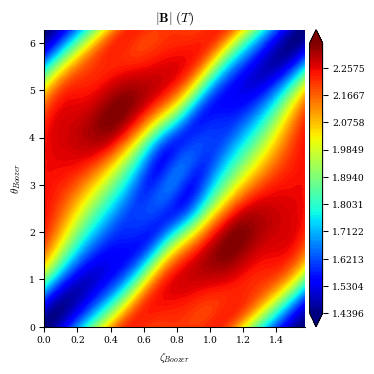

In [19]:
plot_boozer_surface(eq_qs_C);  # |B| contours at rho=1 surface

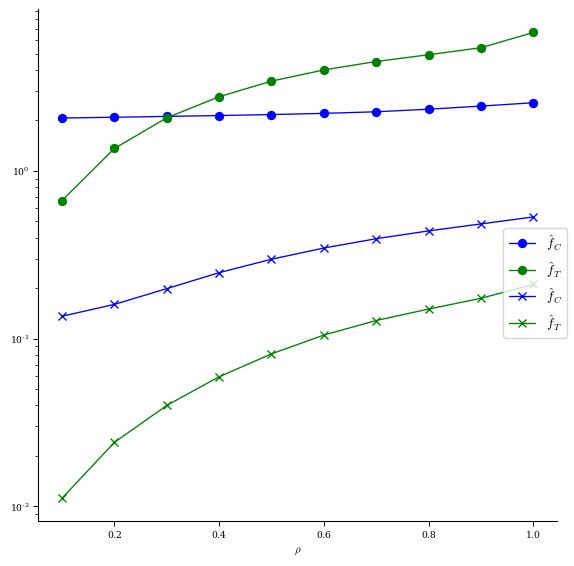

In [20]:
# compare f_T & f_C before (o) vs after (x) optimization
fig, ax = plot_qs_error(eq_init, helicity=(1, eq_init.NFP), fB=False, legend=False, rho=10);
plot_qs_error(eq_qs_C, helicity=(1, eq_init.NFP), fB=False, ax=ax, markers=["x", "x"], rho=10);

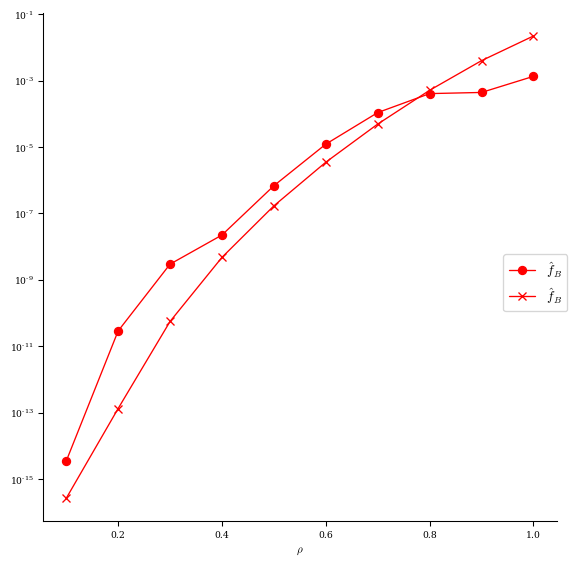

In [21]:
# compare f_B before (o) vs after (x) optimization
fig, ax = plot_qs_error(eq_init, helicity=(1, eq_init.NFP), fT=False, fC=False, legend=False, rho=10);
plot_qs_error(eq_qs_C, helicity=(1, eq_init.NFP), fT=False, fC=False, ax=ax, markers=["x"], rho=10);

## Combining Multiple Objectives

It is very easy in DESC to combine multiple optimization objectives with relative weights between them. Here is an example of how to create an objective optimizing for both $f_B$ and a target aspect ratio: 

In [22]:
objective = ObjectiveFunction(
    (
        QuasisymmetryBoozer(helicity=(1, eq_init.NFP), weight=1e-2),
        AspectRatio(target=6, weight=1e1),
    )
)